In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


2025-03-24 22:56:39.118167: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 22:56:39.137656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742837199.166194   33761 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742837199.175245   33761 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 22:56:39.217876: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Path to your trained linear probe model
model_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/Models/SimCLR_Pretrained/best_LP_Model/best_simclr_linear_probe_model.keras"

# Load the model
linear_probe_model = tf.keras.models.load_model(model_path)
print("✅ Linear Probe Model Loaded!")


I0000 00:00:1742837203.397920   33761 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2051 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


✅ Linear Probe Model Loaded!


In [3]:
# Constants
NUM_CROPS = 9
NUM_DISEASES = 33
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Feature description for parsing TFRecord
feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "crop": tf.io.FixedLenFeature([], tf.int64),
    "disease": tf.io.FixedLenFeature([], tf.int64)
}

def parse_tfrecord(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed["image"], channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    crop = tf.one_hot(parsed["crop"], depth=NUM_CROPS)
    disease = tf.one_hot(parsed["disease"], depth=NUM_DISEASES)
    return image, {"crop_output": crop, "disease_output": disease}

def load_dataset(path):
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

test_tfrecord_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/Dataset/PlantVillage_Structured/AUG_TFRecord/split/test.tfrecord"
test_dataset = load_dataset(test_tfrecord_path)
print("✅ Test Dataset Loaded!")


✅ Test Dataset Loaded!


In [4]:
true_crop_labels = []
true_disease_labels = []
pred_crop_labels = []
pred_disease_labels = []

for batch in test_dataset:
    images, labels = batch
    true_crop_labels.extend(tf.argmax(labels['crop_output'], axis=1).numpy())
    true_disease_labels.extend(tf.argmax(labels['disease_output'], axis=1).numpy())

    preds = linear_probe_model.predict(images, verbose=0)
    pred_crop_labels.extend(np.argmax(preds[0], axis=1))
    pred_disease_labels.extend(np.argmax(preds[1], axis=1))

true_crop_labels = np.array(true_crop_labels)
true_disease_labels = np.array(true_disease_labels)
pred_crop_labels = np.array(pred_crop_labels)
pred_disease_labels = np.array(pred_disease_labels)

print("✅ Predictions completed!")


2025-03-24 22:56:49.563706: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
I0000 00:00:1742837215.846924   33872 service.cc:148] XLA service 0x7f45a0004350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742837215.847112   33872 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-03-24 22:56:56.067437: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742837217.421361   33872 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-24 22:56:58.910641: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 144 bytes spill stores, 144 bytes spill loads

2025-03-24 22:56:59.034664: I external

✅ Predictions completed!


2025-03-24 22:57:22.669688: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Classification Report
print("\n📊 Crop Classification Report:")
print(classification_report(true_crop_labels, pred_crop_labels))

print("\n📊 Disease Classification Report:")
print(classification_report(true_disease_labels, pred_disease_labels))



📊 Crop Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       490
           1       0.92      0.88      0.90       237
           2       0.92      0.91      0.92       199
           3       0.97      0.98      0.97       424
           4       0.93      0.94      0.94       481
           5       0.91      0.90      0.91       331
           6       0.87      0.91      0.89       277
           7       0.93      0.96      0.95       201
           8       0.97      0.96      0.96      1901

    accuracy                           0.94      4541
   macro avg       0.93      0.93      0.93      4541
weighted avg       0.94      0.94      0.94      4541


📊 Disease Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       108
           1       0.93      0.93      0.93       108
           2       0.94      0.97      0.95       108
           3 

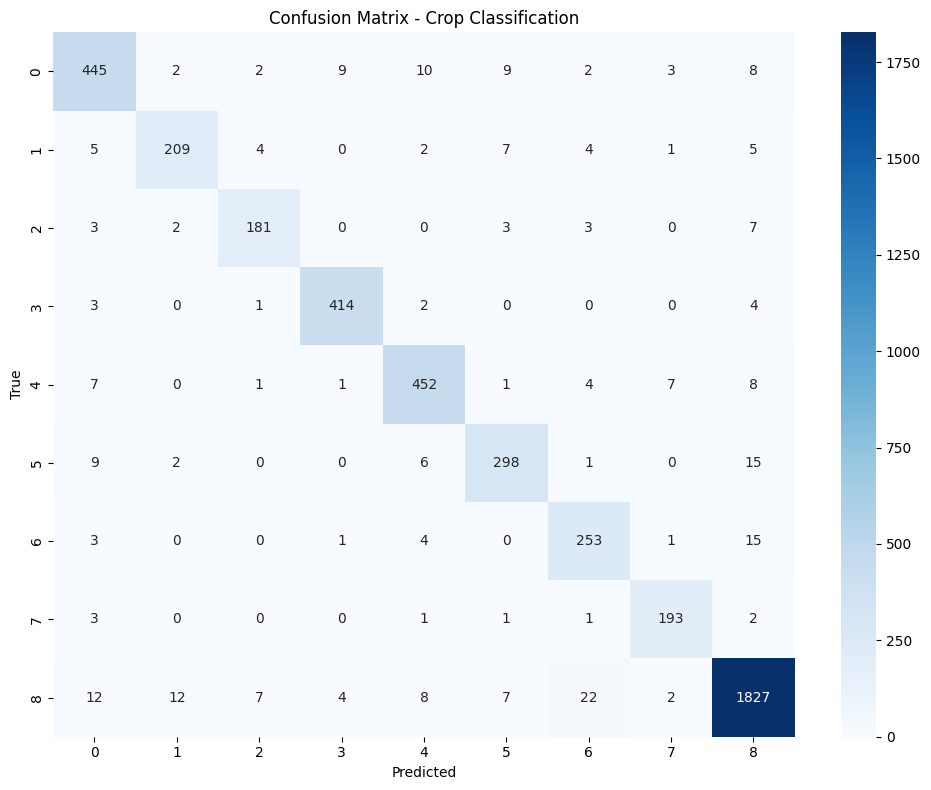

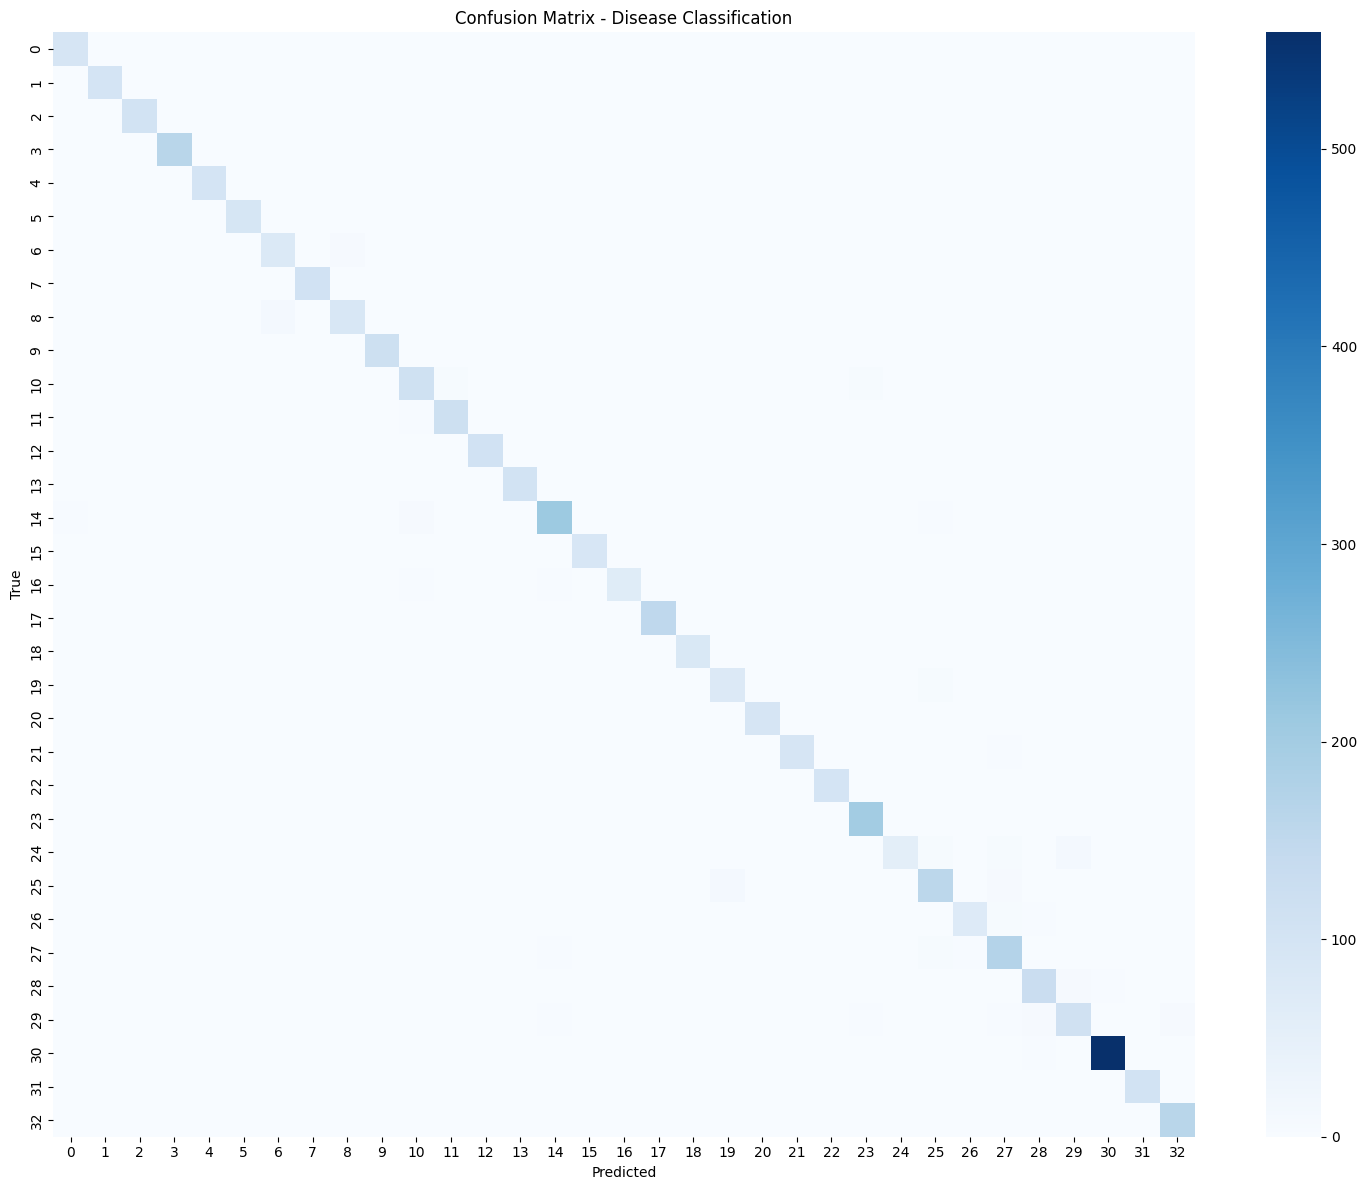

In [6]:
# Create output folder
output_dir = "/home/srivatsa/Multiple_Crop_Disease_Detection/reports/simCLR/Linear_Probe/Plots"
os.makedirs(output_dir, exist_ok=True)

# Confusion Matrix for Crop
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(true_crop_labels, pred_crop_labels), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Crop Classification")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix_crop.png"))
plt.show()

# Confusion Matrix for Disease
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(true_disease_labels, pred_disease_labels), annot=False, cmap="Blues")
plt.title("Confusion Matrix - Disease Classification")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix_disease.png"))
plt.show()


In [7]:
# Save classification reports
with open(os.path.join(output_dir, "classification_report_crop.txt"), "w") as f:
    f.write("Crop Classification Report:\n")
    f.write(classification_report(true_crop_labels, pred_crop_labels))

with open(os.path.join(output_dir, "classification_report_disease.txt"), "w") as f:
    f.write("Disease Classification Report:\n")
    f.write(classification_report(true_disease_labels, pred_disease_labels))


In [8]:
# Class mappings — modify these based on your preprocessing label mapping
crop_label_map = {
    0: "Grape", 1: "Apple", 2: "Bell_Pepper", 3: "Corn",
    4: "Strawberry", 5: "Tomato", 6: "Cherry", 7: "Peach", 8: "Potato"
}

disease_label_map = {
    0: "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    1: "Grape___Esca_(Black_Measles)",
    2: "Grape___Black_rot",
    3: "Grape___healthy",
    4: "Apple___Black_rot",
    5: "Apple___Cedar_apple_rust",
    6: "Apple___Apple_scab",
    7: "Apple___healthy",
    8: "Pepper_bell___Bacterial_spot",
    9: "Pepper_bell___healthy",
    10: "Corn___Common_rust",
    11: "Corn___Cercospora_leaf_spot_Gray_leaf_spot",
    12: "Corn___Northern_Leaf_Blight",
    13: "Corn___healthy",
    14: "Strawberry___healthy",
    15: "Strawberry___Leaf_scorch",
    16: "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    17: "Tomato___Bacterial_spot",
    18: "Tomato___Target_Spot",
    19: "Tomato___Leaf_Mold",
    20: "Tomato___Septoria_leaf_spot",
    21: "Tomato___Tomato_mosaic_virus",
    22: "Tomato___healthy",
    23: "Tomato___Early_blight",
    24: "Tomato___Late_blight",
    25: "Tomato___Spider_mites_Two-spotted_spider_mite",
    26: "Cherry___Powdery_mildew",
    27: "Cherry___healthy",
    28: "Peach___Bacterial_spot",
    29: "Peach___healthy",
    30: "Potato___healthy",
    31: "Potato___Late_blight",
    32: "Potato___Early_blight",
    33: "Background_without_leaves",
    34: "Orange___Haunglongbing_(Citrus_greening)",
    35: "Blueberry___healthy",
    36: "Raspberry___healthy",
    37: "Soybean___healthy"
}

with open(os.path.join(output_dir, "crop_label_mapping.txt"), "w") as f:
    f.write("Crop Label Mapping:\n")
    for k, v in crop_label_map.items():
        f.write(f"{k}: {v}\n")

with open(os.path.join(output_dir, "disease_label_mapping.txt"), "w") as f:
    f.write("Disease Label Mapping:\n")
    for k, v in disease_label_map.items():
        f.write(f"{k}: {v}\n")
